# Milestone 1 (Phase 1) (Modeling)

```sql
SELECT limit_balance, CAST(sex AS INTEGER) AS sex,
       CAST(education_level AS INTEGER) AS education_level,
       CAST(marital_status AS INTEGER) AS marital_status,
       age, pay_0, pay_2, pay_3, pay_4,
       CAST(pay_5 AS DECIMAL) AS pay_5,
       CAST(pay_6 AS DECIMAL) AS pay_6,
       bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5,
       bill_amt_6,pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4,
       pay_amt_5, pay_amt_6,
       CAST(default_payment_next_month AS INTEGER) as default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 5985
```

## Introduction
### Identity
```txt
Name : Andre Lie
Class : FTDS (Offline)
Batch : 03

### Objective Statement
create Classification model for predict default_payment_next_month and using the dataset you have saved.

### Problem Statement
what is the best model for predict this dataset ?

### Conceptual Problem

A. What's the meaning of criterion on Decision Tree ? explain the criterion you using on this case !
   * The methode to measure the quality of a split. 
   * Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
  
Reff :
   1. https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d#:~:text=criterion%20%3A%20This%20parameter%20determines%20how,is%20set%20to%20%E2%80%9Cbest%E2%80%9D.
   2. https://en.wikipedia.org/wiki/Decision_tree_learning

B. Explain what's the meaning with pruning on tree-based model(reason, definition, type, etc) !
   * Pruning is a data compression technique in machine learning and search algorithms that reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.
   
Reff : https://en.wikipedia.org/wiki/Decision_tree_pruning
   
C. How to select optimal K on KNN ?
   * The optimal K value usually found is the square root of N, where N is the total number of samples. Use an error plot or accuracy plot to find the most favorable K value.

Reff : https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb#:~:text=The%20optimal%20K%20value%20usually,be%20aware%20of%20the%20outliers.
   
D. Explain what's the meaning of Cross Validation !
   * Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data.

Reff : https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html#:~:text=Cross%2Dvalidation%20is%20a%20technique,failing%20to%20generalize%20a%20pattern.
   
E. What's metrics : Accuracy, Precision, Recall, F1 Score, and when is the right time to using them?
   * Accuracy represents the number of correctly classified data instances over the total number of data instances. Accuracy may not be a good measure if the dataset is not balanced (both negative and positive classes have different number of data instances).
   * precision is total value of true positive from all data show positive (true positive and false positive). we can say the precision is represetative of how many false positive prediction we got. more low precision, more many false prediction we got. precision be a good measure if the dataset is not balanced and we want to focus on false positive prediction.
   * recall is total value of true positive from data true positive + false negative. we can say the recall is represetative of how many false negative prediction we got. more low recall, more many false negative we got. recall be a good measure if the dataset is not balanced and we want to focus on false negative prediction.
   * F1 score is the harmonic mean of precision and recall and is a better measure than accuracy. F1 score be a good measure when the dataset is balanced or not balanced and when precision and recall doesn't have any difference significantly.

Reff : https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd

## Import Library

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [64]:
pd.set_option('display.max_columns', None)

In [65]:
# read dataset from csv type file
df = pd.read_csv('h8dsft_P1M1_AndreLie.csv')
df

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0,0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0,0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
3,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0,0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
4,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0,0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,30000.0,2,3,2,50.0,-1.0,-1.0,2.0,-1.0,-1,-2,178.0,1860.0,940.0,1110.0,0.0,0.0,1860.0,0.0,1110.0,0.0,0.0,0.0,1
2961,20000.0,2,1,2,25.0,-1.0,-1.0,-1.0,-1.0,-1,-2,2650.0,0.0,855.0,640.0,0.0,0.0,0.0,855.0,640.0,0.0,0.0,2742.0,0
2962,280000.0,2,1,2,52.0,-1.0,-1.0,-1.0,-1.0,-2,-2,886.0,0.0,930.0,0.0,0.0,0.0,0.0,930.0,0.0,0.0,0.0,0.0,0
2963,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2,-2,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0


In [66]:
# show 10 header datas
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0,0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0,0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
3,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0,0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
4,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0,0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0
5,500000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0,0,155820.0,171565.0,184782.0,152365.0,139757.0,153348.0,20000.0,20241.0,20154.0,20019.0,20151.0,20037.0,0
6,50000.0,1,2,1,40.0,0.0,0.0,0.0,0.0,0,0,49073.0,49531.0,44002.0,44356.0,19344.0,19354.0,1691.0,1942.0,1296.0,674.0,693.0,1000.0,0
7,100000.0,1,5,1,45.0,0.0,0.0,0.0,0.0,0,0,94502.0,95697.0,98222.0,90500.0,82586.0,22620.0,5000.0,5000.0,3203.0,2103.0,50000.0,0.0,0
8,140000.0,1,2,1,29.0,0.0,0.0,0.0,0.0,0,0,130767.0,134946.0,130470.0,132038.0,131961.0,124256.0,6696.0,5000.0,4866.0,5300.0,5055.0,5000.0,0
9,50000.0,1,2,1,43.0,0.0,0.0,0.0,0.0,0,0,48919.0,48775.0,48731.0,48934.0,29116.0,28999.0,1800.0,2200.0,1400.0,582.0,580.0,30000.0,0


In [67]:
# show 10 footer datas
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,300000.0,2,2,1,28.0,-1.0,-1.0,-1.0,-1.0,-2,-2,16666.0,1000.0,16666.0,0.0,0.0,0.0,1000.0,16666.0,0.0,0.0,0.0,0.0,0
2956,200000.0,2,1,1,49.0,-1.0,-1.0,-1.0,-1.0,-2,-2,413.0,0.0,103.0,0.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0,225.0,0
2957,50000.0,2,1,2,31.0,-1.0,0.0,-1.0,-1.0,-1,-2,12725.0,34526.0,12787.0,3995.0,0.0,0.0,30018.0,12787.0,3995.0,0.0,0.0,0.0,0
2958,50000.0,2,1,2,25.0,-1.0,-1.0,2.0,-1.0,-1,-2,13572.0,17983.0,15590.0,10610.0,0.0,0.0,5000.0,200.0,10610.0,0.0,0.0,0.0,0
2959,100000.0,2,1,2,37.0,-1.0,-1.0,0.0,-1.0,-1,-2,1725.0,21711.0,10487.0,780.0,0.0,0.0,21711.0,1000.0,780.0,0.0,0.0,0.0,0
2960,30000.0,2,3,2,50.0,-1.0,-1.0,2.0,-1.0,-1,-2,178.0,1860.0,940.0,1110.0,0.0,0.0,1860.0,0.0,1110.0,0.0,0.0,0.0,1
2961,20000.0,2,1,2,25.0,-1.0,-1.0,-1.0,-1.0,-1,-2,2650.0,0.0,855.0,640.0,0.0,0.0,0.0,855.0,640.0,0.0,0.0,2742.0,0
2962,280000.0,2,1,2,52.0,-1.0,-1.0,-1.0,-1.0,-2,-2,886.0,0.0,930.0,0.0,0.0,0.0,0.0,930.0,0.0,0.0,0.0,0.0,0
2963,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2,-2,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2964,100000.0,2,1,2,30.0,-1.0,-1.0,-1.0,-1.0,-2,-2,430.0,35993.0,2772.0,0.0,0.0,0.0,35993.0,2772.0,0.0,0.0,0.0,0.0,0


because the data taken from google cloud platform, we need to describe each column for know the information they contain. we take description of each column from google cloud platform.

|No|Column Name|Description|
|-|----|----|
|1|Balance Limit|Amount of given credit in New Taiwan Dollars (NTD)|
|2|sex|1 = Male <br> 2 = Female|
|3|education level|1 = graduate school <br> 2 = university <br> 3 = high school <br> 4 = others <br> 5 & 6 = unknown|
|4|marital_status|1 = married <br> 2 = single <br> 3 = others|
|5|age|age in years|
|6|pay_0|Repayment status in September, 2005: <br> -1 = pay duly <br> 0 = ontime payment <br> 1 = payment delay for one month <br> 2 = payment delay for two months, ... <br> 8 = payment delay for eight months <br> 9 = payment delay for nine months and above)|
|7|pay_2|Repayment status in August, 2005 (scale same as above)|
|8|pay_3|Repayment status in July, 2005 (scale same as above)|
|9|pay_4|Repayment status in June, 2005 (scale same as above)|
|10|pay_5|Repayment status in May, 2005 (scale same as above)|
|11|pay_6|Repayment status in April, 2005 (scale same as above)|
|12|bill_amt_1|Amount of bill statement in September, 2005 (NTD)|
|13|bill_amt_2|Amount of bill statement in August, 2005 (NTD)|
|14|bill_amt_3|Amount of bill statement in July, 2005 (NTD)|
|15|bill_amt_4|Amount of bill statement in Juny, 2005 (NTD)|
|16|bill_amt_5|Amount of bill statement in May, 2005 (NTD)|
|17|bill_amt_6|Amount of bill statement in April, 2005 (NTD)|
|18|pay_amt_1|Amount of previous payment in September, 2005 (NTD)|
|19|pay_amt_2|Amount of previous payment in August, 2005 (NTD)|
|20|pay_amt_3|Amount of previous payment in July, 2005 (NTD)|
|21|pay_amt_4|Amount of previous payment in Juny, 2005 (NTD)|
|22|pay_amt_5|Amount of previous payment in May, 2005 (NTD)|
|23|pay_amt_6|Amount of previous payment in April, 2005 (NTD)|
|24|default_payment_next_month|Default payment: <br> 1=yes <br> 0=no|

In [68]:
# look for length
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   int64  
 10  pay_6                       2965 non-null   int64  
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

base on database info all columns not have missing values inputation (2965 of 2965 data inputation), but we need to see more depth are the data have strange inputation or not.

In [69]:
#check dataset overview
df.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,-0.254637,52118.305228,50649.153120,48239.757504,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,1.167305,72328.670541,70785.001588,68145.710745,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-11545.000000,-67526.000000,-25443.000000,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3958.000000,3390.000000,3302.000000,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24257.000000,23111.000000,21520.000000,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69852.000000,67827.000000,63023.000000,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,7.000000,613860.000000,512650.000000,578971.000000,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


base on data mayority columns have big range between max value and value on percentile 75% (in range 2 - 4 multiplier) so maybe our data have so many outlier, but we need to see it more.

for making easy to read we will chance the columns name.

In [70]:
df.rename(columns={'pay_0' : 'stat_pay_sep', 'pay_2' : 'stat_pay_aug', 'pay_3' : 'stat_pay_jul',
                   'pay_4' : 'stat_pay_jun', 'pay_5' : 'stat_pay_may', 'pay_6' : 'stat_pay_apr',
                   'bill_amt_1' : 'bill_sep', 'bill_amt_2' : 'bill_aug', 'bill_amt_3' : 'bill_jul',
                   'bill_amt_4' : 'bill_jun', 'bill_amt_5' : 'bill_may', 'bill_amt_6' : 'bill_apr',
                   'pay_amt_1' : 'pay_sep', 'pay_amt_2' : 'pay_aug', 'pay_amt_3' : 'pay_jul',
                   'pay_amt_4' : 'pay_jun', 'pay_amt_5' : 'pay_may', 'pay_amt_6' : 'pay_apr',
                   'default_payment_next_month' : 'fault_payment'},inplace=True)

## Exploratory Data Analysis (EDA)

### Search Corelations between features and target

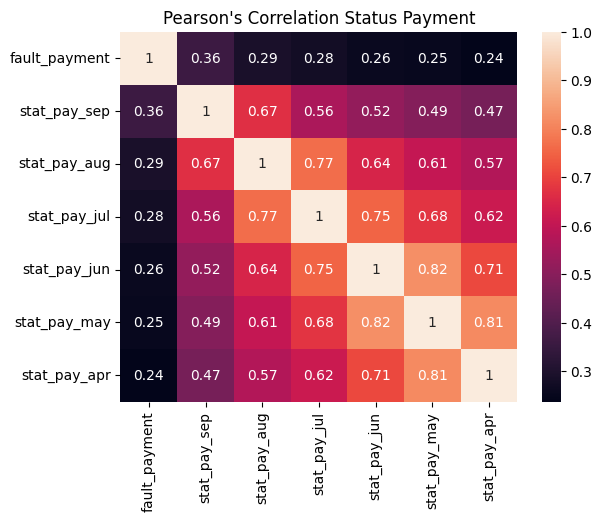

In [71]:
# search correlation between bill payment and stat pay
stat_pay_corr = ['fault_payment','stat_pay_sep', 'stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun', 'stat_pay_may', 'stat_pay_apr']
sns.heatmap(data=df[stat_pay_corr].corr(), annot=True)
plt.title("Pearson's Correlation Status Payment");

base on pearson correlation, stat_pay_apr - sep has low correlation with fault_payment

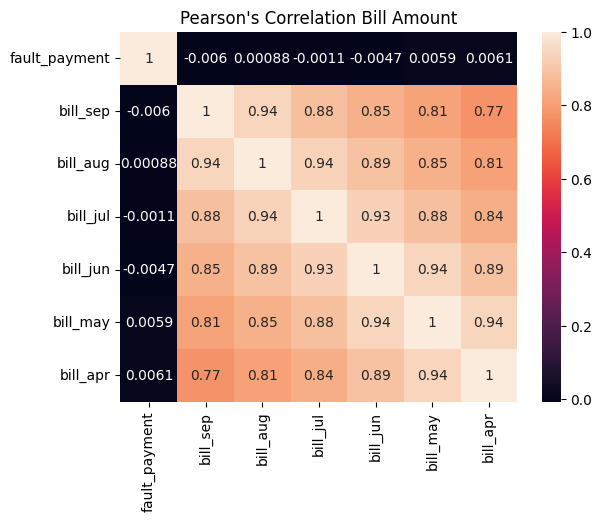

In [72]:
# search correlation between bill payment and bill amount
bill_corr = ['fault_payment', 'bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr']
sns.heatmap(data=df[bill_corr].corr(), annot=True)
plt.title("Pearson's Correlation Bill Amount");

base on pearson correlation, bill_apr - sep has doesn't have correlation with fault_payment

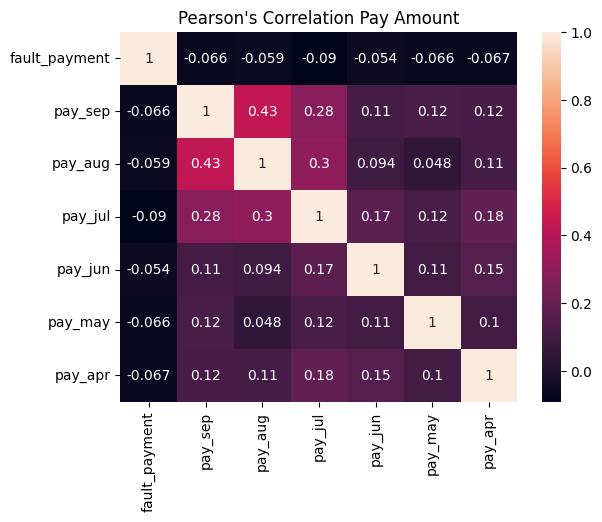

In [73]:
# search correlation between bill payment and payment amount
pay_corr = ['fault_payment', 'pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr']
sns.heatmap(data=df[pay_corr].corr(), annot=True)
plt.title("Pearson's Correlation Pay Amount");

same like bill_apr - sep, pay_apr - sep has doesn't have correlation with fault_payment

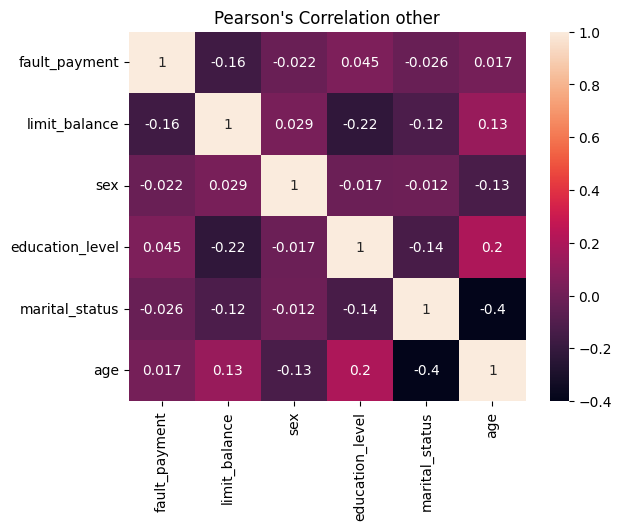

In [74]:
# search correlation between bill payment and other
other_corr = ['fault_payment', 'limit_balance', 'sex', 'education_level', 'marital_status', 'age']
sns.heatmap(data=df[other_corr].corr(), annot=True)
plt.title("Pearson's Correlation other");

as we can see, on other columns doesn't have any correlation too with fault_payment expect that limit_balance.

from 4 combinations correlation with fault_payment, i prefer to pick status payment & limit balance as our features.

### Look at Data Distributions

limit_balance Skewness Level : 1.0004416437793326
limit_balance is right skew



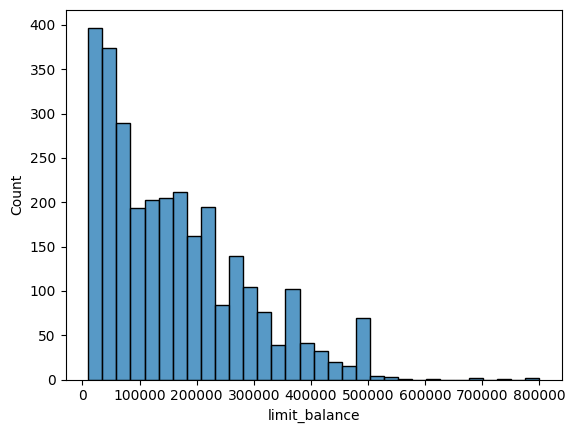

In [75]:
# plot distribution of data features and target
sns.histplot(data=df['limit_balance']);

# show skewness level and determine whatever the column is skew or normal distribution
for col in df[['limit_balance']]:
    print(df[col].name,'Skewness Level :', df[col].skew())
    if df[col].skew() > 0.5 :
        print(df[col].name,'is right skew')
    elif df[col].skew() < -0.5 :
        print(df[col].name,'is left skew')
    else :
        print(df[col].name,'is normal distributed')
    print("")

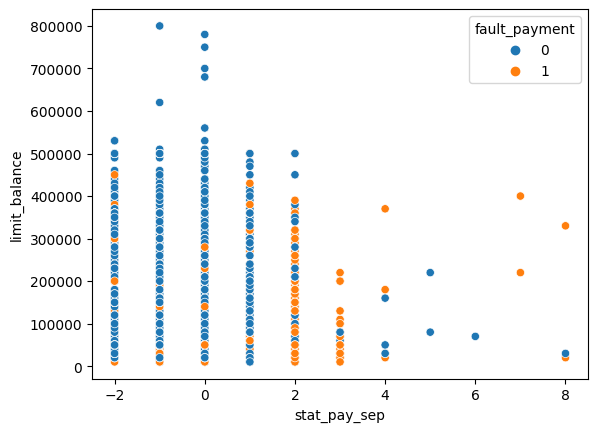

In [76]:
# Status payment sep vs limit balance vs bill payment
sns.scatterplot(x='stat_pay_sep', y='limit_balance', data=df, hue='fault_payment');

as we can see, if clien have more big limit balance they will pay them bills, but more have long delayed payment they willn't pay it on next month.

### Search features & target proportion

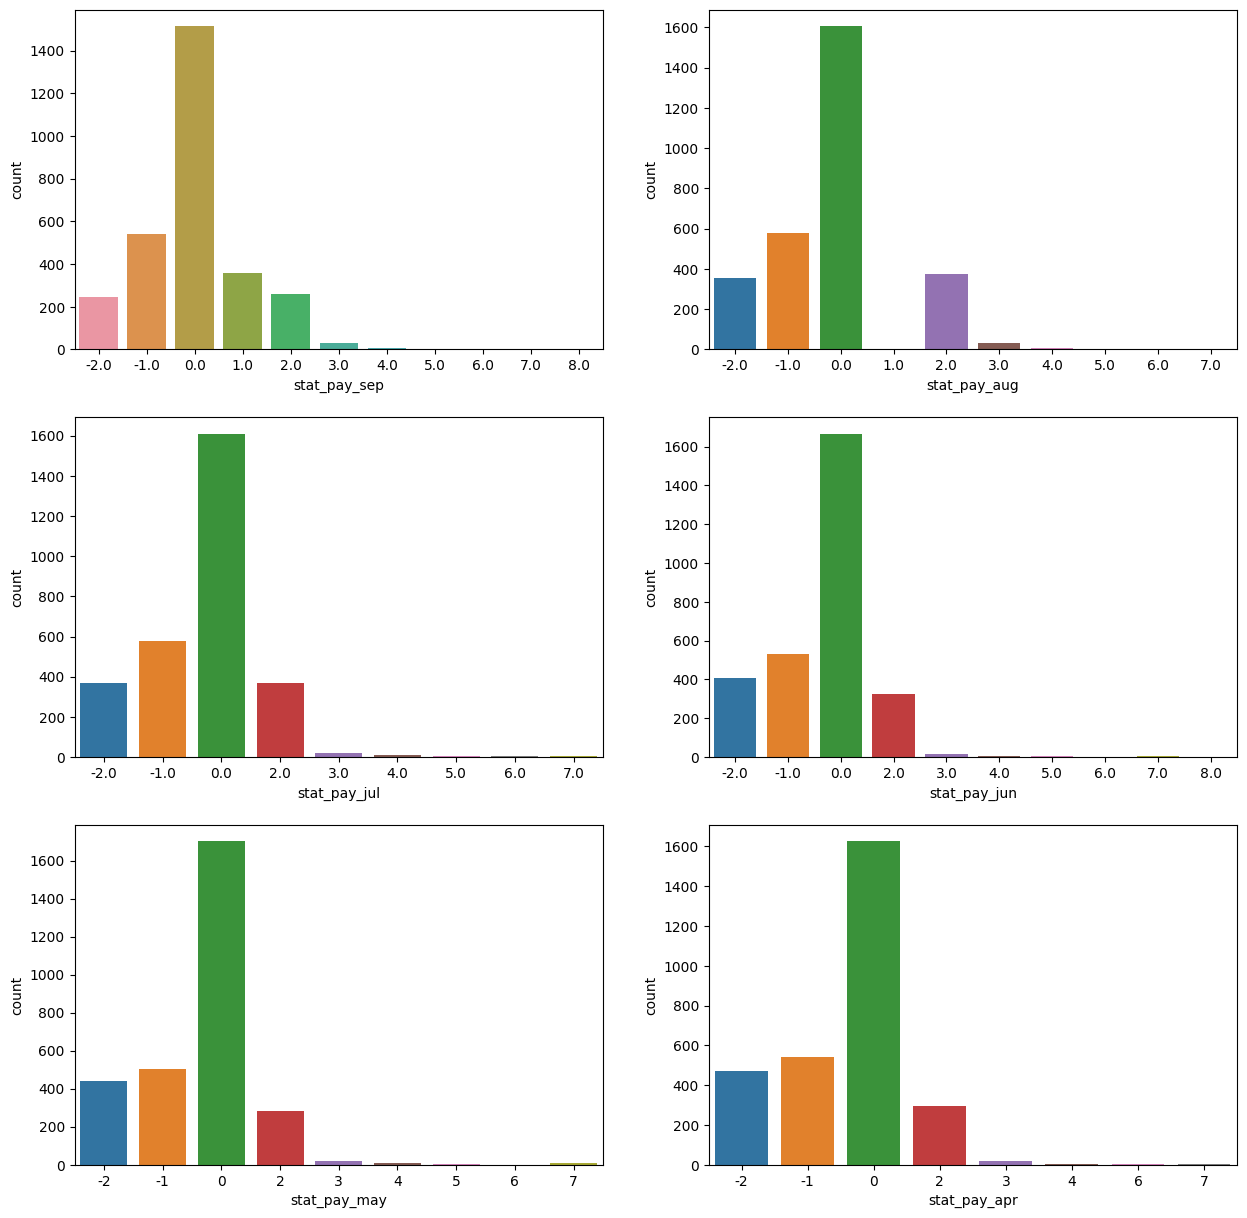

In [77]:
# show proportion of data features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
axes = axes.flatten()
sns.countplot(x='stat_pay_sep', data=df, ax=axes[0])
sns.countplot(x='stat_pay_aug', data=df, ax=axes[1])
sns.countplot(x='stat_pay_jul', data=df, ax=axes[2])
sns.countplot(x='stat_pay_jun', data=df, ax=axes[3])
sns.countplot(x='stat_pay_may', data=df, ax=axes[4])
sns.countplot(x='stat_pay_apr', data=df, ax=axes[5]);

for all stat_pay_apr - sep the mayority of data is 0 category (ontime payment)

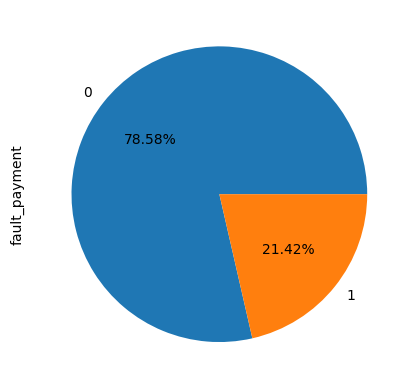

In [78]:
#plot pie chart for look target columns proportion
df['fault_payment'].value_counts().plot(kind='pie', autopct='%.2f%%');

1. the data tell that people who pay them bills on next month is more many than they who cant pay them bills. 
2. our data target is not balance, we need to stratify them on split for minimalization data test doesn't have one category.

## Data Preprocessing

### Look Multicolinearity 

In [79]:
# VIF Calculator
def vif(c):
    vif = pd.DataFrame()
    vif['Column'] = c.columns
    vif['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]

    return vif

In [80]:
#search for multicolinearity
vif(df[['stat_pay_sep', 'stat_pay_aug', 
        'stat_pay_jul', 'stat_pay_jun',
        'stat_pay_may', 'stat_pay_apr',
        'limit_balance']])

,Column,VIF
0,stat_pay_sep,1.845663
1,stat_pay_aug,3.132112
2,stat_pay_jul,3.404884
3,stat_pay_jun,4.084622
4,stat_pay_may,4.816025
5,stat_pay_apr,3.212958
6,limit_balance,1.123589


since our data feature doesn't > 5 it's mean they don't have multicolinearity (same information)

### Look Cardinality

In [81]:
# show number of unique data on category features
for i in df[['stat_pay_sep', 'stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun', 'stat_pay_may', 'stat_pay_apr']]:
    print(i,df[i].nunique())

stat_pay_sep 11
stat_pay_aug 10
stat_pay_jul 9
stat_pay_jun 10
stat_pay_may 9
stat_pay_apr 8


wow, our feature on column stat_pay_sep, stat_pay_aug, stat_pay_jun have high cardinality. but before we handle this cardinality, let's find comparison they information with bill payment.

In [82]:
# search patern data from fault_payment vs stat_pay_sep
df.groupby('stat_pay_sep')['fault_payment'].value_counts()

stat_pay_sep  fault_payment
-2.0          0                 213
              1                  34
-1.0          0                 474
              1                  66
 0.0          0                1319
              1                 197
 1.0          0                 245
              1                 111
 2.0          1                 193
              0                  69
 3.0          1                  26
              0                   3
 4.0          1                   4
              0                   3
 5.0          0                   2
 6.0          0                   1
 7.0          1                   2
 8.0          1                   2
              0                   1
Name: fault_payment, dtype: int64

In [83]:
# search patern data from fault_payment vs stat_pay_aug
df.groupby('stat_pay_aug')['fault_payment'].value_counts()

stat_pay_aug  fault_payment
-2.0          0                 295
              1                  58
-1.0          0                 503
              1                  77
 0.0          0                1349
              1                 258
 1.0          0                   4
 2.0          1                 213
              0                 161
 3.0          1                  22
              0                  10
 4.0          0                   5
              1                   3
 5.0          0                   2
 6.0          1                   2
 7.0          1                   2
              0                   1
Name: fault_payment, dtype: int64

In [84]:
# search patern data from fault_payment vs stat_pay_jul
df.groupby('stat_pay_jul')['fault_payment'].value_counts()

stat_pay_jul  fault_payment
-2.0          0                 306
              1                  61
-1.0          0                 498
              1                  82
 0.0          0                1345
              1                 265
 2.0          1                 201
              0                 167
 3.0          1                  13
              0                   9
 4.0          0                   4
              1                   4
 5.0          1                   3
 6.0          1                   3
              0                   1
 7.0          1                   3
Name: fault_payment, dtype: int64

In [85]:
# search patern data from fault_payment vs stat_pay_jun
df.groupby('stat_pay_jun')['fault_payment'].value_counts()

stat_pay_jun  fault_payment
-2.0          0                 340
              1                  68
-1.0          0                 454
              1                  78
 0.0          0                1380
              1                 287
 2.0          1                 178
              0                 146
 3.0          1                   9
              0                   5
 4.0          1                   6
              0                   1
 5.0          1                   3
              0                   2
 6.0          1                   1
 7.0          1                   5
              0                   1
 8.0          0                   1
Name: fault_payment, dtype: int64

In [86]:
# search patern data from fault_payment vs stat_pay_may
df.groupby('stat_pay_may')['fault_payment'].value_counts()

stat_pay_may  fault_payment
-2            0                 366
              1                  75
-1            0                 438
              1                  66
 0            0                1394
              1                 308
 2            1                 160
              0                 120
 3            1                  13
              0                   6
 4            1                   5
              0                   4
 5            1                   2
 6            1                   1
 7            1                   5
              0                   2
Name: fault_payment, dtype: int64

In [87]:
# search patern data from fault_payment vs stat_pay_apr
df.groupby('stat_pay_apr')['fault_payment'].value_counts()

stat_pay_apr  fault_payment
-2            0                 393
              1                  77
-1            0                 459
              1                  81
 0            0                1330
              1                 296
 2            1                 161
              0                 136
 3            1                  11
              0                  10
 4            1                   2
 6            1                   2
              0                   1
 7            1                   5
              0                   1
Name: fault_payment, dtype: int64

as we can see, for each stat pay apr - sep have similiar patern of number client with stat pay category > 3 so we can group them as 1 group.

for stat pay category from -2 till 0 have same meaning that is ontime payment, so we can group they too as 1 group.

In [88]:
#replace 1
df[['stat_pay_sep','stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun',
    'stat_pay_may', 'stat_pay_apr']] = df[['stat_pay_sep','stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun',
                                           'stat_pay_may', 'stat_pay_apr']].replace(to_replace=[-2, -1], value=0)

#replace 2
df[['stat_pay_sep','stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun',
    'stat_pay_may', 'stat_pay_apr']] = df[['stat_pay_sep','stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun',
                                           'stat_pay_may', 'stat_pay_apr']].replace(to_replace=[5, 6, 7, 8], value=4)

# show cardinality after handling
for a in df[['stat_pay_sep','stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun', 'stat_pay_may', 'stat_pay_apr']] :
        print(a, ':', df[a].nunique())

stat_pay_sep : 5
stat_pay_aug : 5
stat_pay_jul : 4
stat_pay_jun : 4
stat_pay_may : 4
stat_pay_apr : 4


### Look Missing Values

as we know early our data doesn't have missing inputations, let's search more details here if our support data feature have other missing values.

In [89]:
for i in df[['stat_pay_sep', 'stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun',
            'stat_pay_may', 'stat_pay_apr', 'limit_balance']]:
    print(i, ':',df[i].unique())

stat_pay_sep : [0. 2. 3. 4. 1.]
stat_pay_aug : [0. 2. 3. 4. 1.]
stat_pay_jul : [0. 2. 3. 4.]
stat_pay_jun : [0. 2. 3. 4.]
stat_pay_may : [0 2 3 4]
stat_pay_apr : [0 2 3 4]
limit_balance : [130000. 230000. 200000. 500000.  50000. 100000. 140000. 460000.  20000.
  80000. 780000. 420000. 150000. 170000. 180000.  70000. 320000. 110000.
 410000. 210000. 260000. 300000. 290000. 240000. 280000. 340000. 360000.
 390000. 380000. 350000.  90000. 310000. 480000.  30000.  60000. 400000.
 160000. 220000.  10000. 120000. 470000. 250000. 490000. 430000. 330000.
 190000. 370000. 510000. 270000.  40000. 440000. 700000. 530000. 560000.
 680000. 750000. 450000. 800000. 620000.]


after searching more details for missing values in our features we don't found any missing values.

### Look Duplicated Data

In [90]:
#count duplicated data
df.duplicated().value_counts()

False    2964
True        1
dtype: int64

we found 1 duplicate data, let's se what that is that.

In [91]:
#show the duplicated data
df[df.duplicated(keep=False)]

,limit_balance,sex,education_level,marital_status,age,stat_pay_sep,stat_pay_aug,stat_pay_jul,stat_pay_jun,stat_pay_may,stat_pay_apr,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,pay_sep,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,fault_payment
2366,200000.0,2,1,1,34.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2381,200000.0,2,1,1,34.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


is this incidental or not ? we doesn't know that, so the better option is drop that duplicated data.

In [92]:
#check data length before drop duplicate
df.shape

(2965, 24)

In [93]:
#drop duplicated data
df.drop_duplicates(inplace=True, ignore_index=True)
df.shape

(2964, 24)

now our data is clean from duplicated.

### Train-Test Split / Split Dataset

In [94]:
# split data train and data test between features and target
features = df.drop('fault_payment', axis=1)
target = df['fault_payment']

f_train, f_test, t_train, t_test = train_test_split(features, target, test_size=0.4, stratify=target, random_state=2895)

## Feature Engineering

### Look Outlier

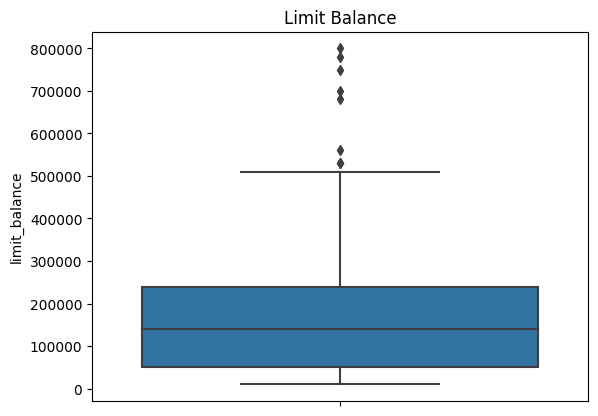

In [95]:
# search outlier from our numberical features
sns.boxplot(y='limit_balance',data=f_train)
plt.title('Limit Balance');

as we can see that limit balance have outlier value and cause the distribution data of limit balance is right skew, so using IQR methode to calculate the outlier.

### Handling Outlier

In [96]:
# define a function for calculating lower and upper boundaries using IQR method
def outlier(data, col, cons):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    
    lower_bound = data[col].quantile(0.25) - (IQR * cons)
    upper_bound = data[col].quantile(0.75) + (IQR * cons)
    
    return lower_bound, upper_bound

we using constant 3 because distance distribution is skew and  skew level more then 1

In [97]:
# show lower and upper boundaries from column limit balance
lower_bound_train, upper_bound_train = outlier(data=f_train, col='limit_balance', cons=1.5)
print('lower boundary train limit balance : ', lower_bound_train)
print('upper boundary train limit balance : ', upper_bound_train)

lower boundary train limit balance :  -235000.0
upper boundary train limit balance :  525000.0


as we know that limit balance is never being a negative number so we will focus on upper boundary only

In [98]:
#show percentage of outlier on columns limit balance
percentage_outlier_train = (f_train['limit_balance'][(f_train['limit_balance'] < lower_bound_train) | (f_train['limit_balance'] > upper_bound_train)].count())/(f_train['limit_balance'].count())*100
print('percentage f_train distance outlier :', percentage_outlier_train, '%')

percentage f_train distance outlier : 0.44994375703037126 %


the presentation of outlier is 0.45%, it means our model is not will change even we handling this outlier. but for make sure the model we will create have best analysis, so we will handle this with capping methode (cause the data entry is few)

In [99]:
# capping the data using iqr
winsor = Winsorizer(capping_method='iqr',
                    tail='right',
                    fold=1.5,
                    variables=['limit_balance'])

f_train = winsor.fit_transform(f_train)

In [100]:
# cross check percentage outlier after capping
percentage_outlier_train = (f_train['limit_balance'][(f_train['limit_balance'] < lower_bound_train) | (f_train['limit_balance'] > upper_bound_train)].count())/(f_train['limit_balance'].count())*100
print('percentage limit balance outlier :', percentage_outlier_train,'%')

percentage limit balance outlier : 0.0 %


now our data already clean from outliers.

### Feature Selection

from correlation exploratory & check multicolinearity we have features :
1. stat_pay_sep
2. stat_pay_aug
3. stat_pay_jul
4. stat_pay_jun
5. stat_pay_may
6. stat_pay_apr

In [101]:
# select features and split to numerical and catergorical
num_f = ['limit_balance']
cat_f = ['stat_pay_sep', 'stat_pay_aug', 'stat_pay_jul', 'stat_pay_jun', 'stat_pay_may', 'stat_pay_apr']

### Feature Scaling

In [102]:
# scaling feature
scaler = MinMaxScaler()
f_train_scaled = scaler.fit_transform(f_train[num_f])
f_test_scaled = scaler.transform(f_test[num_f])

### Feature Encoding

because our categories data is encoded from dataset we got, so we doesn't need to encoding feature anymore.

### Concat Feature Numberic and Categorial Columns

In [103]:
# concat the scaled feature with categorical features
f_train_fix = np.concatenate([f_train_scaled, f_train[cat_f]], axis=1)
f_test_fix = np.concatenate([f_test_scaled, f_test[cat_f]], axis=1)

## Model Definition

In [104]:
# define the models we using in train
model = [LogisticRegression(),SVC(),KNeighborsClassifier(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier()]

In [105]:
# look for best performance model
best_model = []
best_perform = 0

for lop in model:
    cv_score = cross_val_score(lop, f_train, t_train, cv=StratifiedKFold(n_splits=10, random_state=2895, shuffle=True), scoring='recall')
    if cv_score.mean() > best_perform :
        best_model = lop
        best_perform = cv_score.mean()
        
    print(f'Model {lop}')
    print(f'Recall - All - CrossVallidation :{cv_score}')
    print(f'Recall - Mean - CrossVallidation :{cv_score.mean()}')
    print(f'Recall - Std - CrossVallidation :{cv_score.std()}')
    print(f'Recall - Range of Test-Set :{cv_score.mean()-cv_score.std()} - {cv_score.mean()+cv_score.std()}')
    
    print(f'\nBest Model : {best_model}')
    print(f'best_perform : {best_perform}')

Model LogisticRegression()
Recall - All - CrossVallidation :[0.02564103 0.         0.02631579 0.         0.         0.
 0.         0.         0.02631579 0.02631579]
Recall - Mean - CrossVallidation :0.010458839406207825
Recall - Std - CrossVallidation :0.012810742779187643
Recall - Range of Test-Set :-0.002351903372979818 - 0.023269582185395467

Best Model : LogisticRegression()
best_perform : 0.010458839406207825
Model SVC()
Recall - All - CrossVallidation :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Recall - Mean - CrossVallidation :0.0
Recall - Std - CrossVallidation :0.0
Recall - Range of Test-Set :0.0 - 0.0

Best Model : LogisticRegression()
best_perform : 0.010458839406207825
Model KNeighborsClassifier()
Recall - All - CrossVallidation :[0.15384615 0.21052632 0.21052632 0.07894737 0.13157895 0.13157895
 0.13157895 0.05263158 0.13157895 0.18421053]
Recall - Mean - CrossVallidation :0.14170040485829957
Recall - Std - CrossVallidation :0.04869252161671462
Recall - Range of Test-Set :0.093007883

from performance model test, we can use Naive Bayes (gaussianNB) as our best model.

In [106]:
# model selection
model_NB = GaussianNB() 

## Model Training

Default hyperparameter

In [107]:
# Training model using default hyperparameter
model_NB.fit(f_train_fix, t_train)
h_train_pred = model_NB.predict(f_train_fix)
h_test_pred = model_NB.predict(f_test_fix)

Hyperparameter Tunning

In [108]:
# Define Hyperparameter for GaussianNB model
var_smoothing = {'var_smoothing': np.logspace(0,-9, num=25)}
var_smoothing

{'var_smoothing': array([1.00000000e+00, 4.21696503e-01, 1.77827941e-01, 7.49894209e-02,
        3.16227766e-02, 1.33352143e-02, 5.62341325e-03, 2.37137371e-03,
        1.00000000e-03, 4.21696503e-04, 1.77827941e-04, 7.49894209e-05,
        3.16227766e-05, 1.33352143e-05, 5.62341325e-06, 2.37137371e-06,
        1.00000000e-06, 4.21696503e-07, 1.77827941e-07, 7.49894209e-08,
        3.16227766e-08, 1.33352143e-08, 5.62341325e-09, 2.37137371e-09,
        1.00000000e-09])}

In [109]:
# tunning hyperparameter using Random Search
rs_tunning = RandomizedSearchCV(estimator=model_NB,
                                param_distributions=var_smoothing,
                                n_iter=25,
                                cv=StratifiedKFold(n_splits=10, random_state=2895, shuffle=True),
                                n_jobs=-1,
                                scoring='recall',
                                random_state=2895)
rs_tunning.fit(f_train_fix, t_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2895, shuffle=True),
                   estimator=GaussianNB(), n_iter=25, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 4.21696503e-01, 1.77827941e-01, 7.49894209e-02,
       3.16227766e-02, 1.33352143e-02, 5.62341325e-03, 2.37137371e-03,
       1.00000000e-03, 4.21696503e-04, 1.77827941e-04, 7.49894209e-05,
       3.16227766e-05, 1.33352143e-05, 5.62341325e-06, 2.37137371e-06,
       1.00000000e-06, 4.21696503e-07, 1.77827941e-07, 7.49894209e-08,
       3.16227766e-08, 1.33352143e-08, 5.62341325e-09, 2.37137371e-09,
       1.00000000e-09])},
                   random_state=2895, scoring='recall')

In [110]:
# get Best Hyperparameter
rs_tunning.best_params_

{'var_smoothing': 0.005623413251903491}

from randomsearch tunning, we found best hyperparameter for var_smoothing on 0.005

In [111]:
# get best estimator
rs_tunning_best = rs_tunning.best_estimator_

In [112]:
# predict with best tunning hyperparameters
h_train_pred_tun = rs_tunning_best.predict(f_train_fix)
h_test_pred_tun = rs_tunning_best.predict(f_test_fix)

## Model Evaluation

Comparison of default and tunning hyperparameter

In [113]:
# show classification report of default hyperparameter vs tunning hyperparameter on data train
print('='*10,'Default Hyperparameter (Train)','='*10)
print(classification_report(t_train, h_train_pred))
print('='*10,'Tunning Hyperparameter (Train)','='*10)
print(classification_report(t_train, h_train_pred_tun))

# show classification report of default hyperparameter vs tunning hyperparameter on data test
print('='*10,'Default Hyperparameter (Test)','='*10)
print(classification_report(t_test, h_test_pred))
print('='*10,'Tunning Hyperparameter (Test)','='*10)
print(classification_report(t_test, h_test_pred_tun))

========== Default Hyperparameter (Train) ==========
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1397
           1       0.55      0.53      0.54       381

    accuracy                           0.80      1778
   macro avg       0.71      0.71      0.71      1778
weighted avg       0.80      0.80      0.80      1778

========== Tunning Hyperparameter (Train) ==========
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1397
           1       0.55      0.53      0.54       381

    accuracy                           0.81      1778
   macro avg       0.71      0.71      0.71      1778
weighted avg       0.80      0.81      0.80      1778

========== Default Hyperparameter (Test) ==========
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       932
           1       0.54      0.56      0.55       254

    accuracy            

based on classification report, as we can see that recall 1 on tunning hyperparameter is same with default hyperparameter.

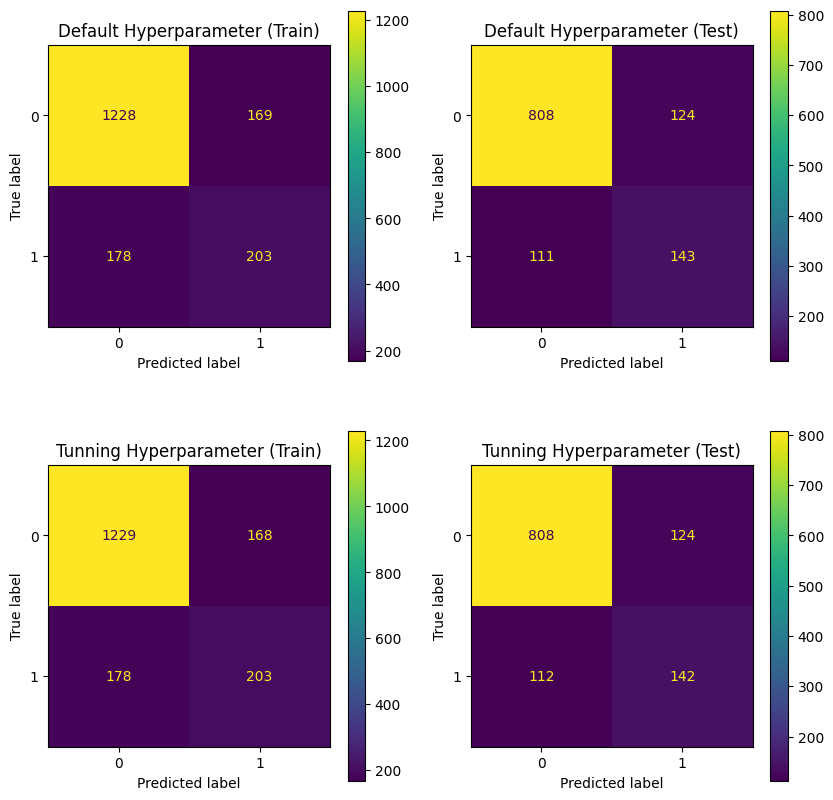

In [114]:
#show confusion matrix from predict train defaults hyperparameter vs tunning hyperparameter
cm_train = confusion_matrix(t_train, h_train_pred, labels=model_NB.classes_)
cm_train_tun = confusion_matrix(t_train, h_train_pred_tun, labels=model_NB.classes_)
cm_test = confusion_matrix(t_test, h_test_pred, labels=model_NB.classes_)
cm_test_tun = confusion_matrix(t_test, h_test_pred_tun, labels=model_NB.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=model_NB.classes_)
disp_test_tun = ConfusionMatrixDisplay(confusion_matrix=cm_test_tun,display_labels=model_NB.classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,display_labels=model_NB.classes_)
disp_train_tun = ConfusionMatrixDisplay(confusion_matrix=cm_train_tun,display_labels=model_NB.classes_)

fig, axes = plt.subplots(2,2, figsize=(10,10))
disp_train.plot(ax=axes[0,0])
axes[0,0].set_title('Default Hyperparameter (Train)')
disp_test.plot(ax=axes[0,1])
axes[0,1].set_title('Default Hyperparameter (Test)')
disp_train_tun.plot(ax=axes[1,0])
axes[1,0].set_title('Tunning Hyperparameter (Train)')
disp_test_tun.plot(ax=axes[1,1])
axes[1,1].set_title('Tunning Hyperparameter (Test)')
plt.show()

based on coffusion matrix our False negative on test data in increase by 1 after we tunning. so the best model we will get is with default hyperparameter.

## Model Saving

In [115]:
# saving model
with open('scaler.pkl', 'wb') as file_1:
  joblib.dump(scaler, file_1)
  
with open('model.pkl', 'wb') as file_2:
  joblib.dump(rs_tunning_best, file_2)
  
with open('num_col.pkl', 'wb') as file_3:
  joblib.dump(num_f, file_3)
  
with open('cat_col.pkl', 'wb') as file_4:
  joblib.dump(cat_f, file_4)